In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [240]:
spotify = pd.read_csv('../data/spotify_top_2024.csv', encoding='latin1')
billboard = pd.read_csv('../data/billboard_top.csv', encoding='latin1')

In [241]:
spotify.columns = spotify.columns.str.lower().str.replace(' ', '_')
billboard.columns = billboard.columns.str.lower().str.replace(' ', '_')

# Rename Spotify columns for consistency
spotify = spotify.rename(columns={
    'track': 'track',
    'artist': 'artist'
})

billboard = billboard.rename(columns={
    'title': 'track',
    'performer': 'artist'
})

In [242]:
import re

def clean_text(s):
    if pd.isna(s):
        return ""
    s = s.lower()
    s = s.strip()

    # remove featuring variations
    s = re.sub(r'\s*\(feat[^\)]*\)', '', s)
    s = re.sub(r'\s*feat\..*', '', s)
    s = re.sub(r'\s*ft\..*', '', s)
    s = re.sub(r'\s*featuring.*', '', s)

    # remove brackets and parentheses like (remix), [remastered], etc.
    s = re.sub(r'\(.*?\)', '', s)
    s = re.sub(r'\[.*?\]', '', s)

    # remove extra spaces
    s = re.sub(r'\s+', ' ', s)

    return s.strip()

# apply to both datasets
for df in [spotify, billboard]:
    df["track"] = df["track"].apply(clean_text)
    df["artist"] = df["artist"].apply(clean_text)

In [243]:
features = [
    'spotify_streams',
    'spotify_playlist_count',
    'spotify_playlist_reach',
    'spotify_popularity',
    'youtube_views',
    'youtube_likes',
    'tiktok_posts',
    'tiktok_likes',
    'tiktok_views'
]

def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    
    x = str(x).strip().lower()
    
    # Replace common missing-value placeholders
    if x in ["", "-", "--", "nan", "none"]:
        return np.nan
    
    # Remove commas
    x = x.replace(",", "")
    
    # Remove words like "views"
    x = re.sub(r"[^\d\.]", "", x)
    
    # Extract numbers only
    match = re.search(r"\d+\.?\d*", x)
    if not match:
        return np.nan
    
    return float(match.group())

# Apply to Spotify only (these columns do not appear in Billboard)
for col in features:
    if col in spotify.columns:
        spotify[col] = spotify[col].apply(clean_numeric)

In [244]:
spotify['release_date'] = pd.to_datetime(spotify['release_date'], errors='coerce')
spotify['release_year'] = spotify['release_date'].dt.year
spotify['release_month'] = spotify['release_date'].dt.month

billboard['chart_week'] = pd.to_datetime(billboard['chart_week'], errors='coerce')
billboard['chart_year'] = billboard['chart_week'].dt.year

spotify_2024 = spotify[spotify['release_year'] == 2024]
billboard_2024 = billboard[billboard['chart_year'] == 2024]

In [219]:
spotify_2024 = spotify[spotify['release_year'] == 2024]
billboard_2024 = billboard[billboard['chart_year'] == 2024]

chart_songs_2024 = set(zip(billboard_2024['track'], billboard_2024['artist']))
spotify_2024['charted_2024'] = (
    pd.Series(list(zip(spotify_2024['track'], spotify_2024['artist'])))
    .isin(chart_songs_2024)
)

spotify_final = spotify_2024.copy()  # all songs released in 2024
final = spotify_final.merge(
    billboard_2024[['track', 'artist', 'current_week', 'peak_pos', 'wks_on_chart']],
    on=['track', 'artist'],
    how='left'
)

final['charted'] = final['current_week'].notna().astype(int)
final['peak_pos'] = final['peak_pos'].fillna(200)       # Did not chart
final['wks_on_chart'] = final['wks_on_chart'].fillna(0)

/var/folders/8v/g4l9gxvd0q7f6kf8_2r2wdj40000gn/T/ipykernel_3205/2324977886.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_2024['charted_2024'] = (


In [246]:
def bucket_peak_position(pos):
    if pos <= 10:
        return "Top10"
    elif pos <= 50:
        return "Top50"
    elif pos <= 100:
        return "Top100"
    elif pos <= 200:
        return "LowChart"
    else:
        return "NoChart"

final['chart_range'] = final['peak_pos'].apply(bucket_peak_position)

In [245]:
final_2024 = final.copy()

features = [
    'spotify_streams',
    'spotify_playlist_count',
    'spotify_playlist_reach',
    'spotify_popularity',
    'youtube_views',
    'youtube_likes',
    'tiktok_posts',
    'tiktok_likes',
    'tiktok_views'
]

In [248]:
train_df = final_2024[final_2024['release_month'] < 5]
predict_df = final_2024[final_2024['release_month'] == 5]

X_train_raw = train_df[features]
y_train_stage1 = (train_df['chart_range'] != "LowChart").astype(int)  # 1 = charted, 0 = low
y_train_stage2 = train_df[train_df['chart_range'] != "LowChart"]['chart_range']

X_train_stage2_raw = train_df[train_df['chart_range'] != "LowChart"][features]

X_pred_raw = predict_df[features]

In [249]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_raw)
X_pred_imp = imputer.transform(X_pred_raw)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_pred_scaled = scaler.transform(X_pred_imp)

# Stage 2 dataset
X_train_stage2_imp = imputer.fit_transform(X_train_stage2_raw)
X_train_stage2_scaled = scaler.fit_transform(X_train_stage2_imp)

In [250]:
rf_stage1 = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42
)

rf_stage1.fit(X_train_scaled, y_train_stage1)
predict_df["stage1_charted_pred"] = rf_stage1.predict(X_pred_scaled)

/var/folders/8v/g4l9gxvd0q7f6kf8_2r2wdj40000gn/T/ipykernel_3205/244937570.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df["stage1_charted_pred"] = rf_stage1.predict(X_pred_scaled)


In [251]:
rf_stage2 = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf_stage2.fit(X_train_stage2_scaled, y_train_stage2)

charted_idx = predict_df["stage1_charted_pred"] == 1
X_pred_stage2 = X_pred_scaled[charted_idx]

stage2_preds = rf_stage2.predict(X_pred_stage2)

predict_df.loc[charted_idx, "stage2_bucket_pred"] = stage2_preds
predict_df.loc[~charted_idx, "stage2_bucket_pred"] = "LowChart"

/var/folders/8v/g4l9gxvd0q7f6kf8_2r2wdj40000gn/T/ipykernel_3205/2451286973.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df.loc[charted_idx, "stage2_bucket_pred"] = stage2_preds


In [252]:
predict_df["final_prediction"] = predict_df["stage2_bucket_pred"]

y_true = predict_df["chart_range"]
y_pred = predict_df["final_prediction"]

/var/folders/8v/g4l9gxvd0q7f6kf8_2r2wdj40000gn/T/ipykernel_3205/3318536510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df["final_prediction"] = predict_df["stage2_bucket_pred"]


In [253]:
print("Two-Stage Model: May 2024 Prediction Results\n")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Two-Stage Model: May 2024 Prediction Results

              precision    recall  f1-score   support

    LowChart       0.80      0.99      0.88       146
       Top10       0.82      0.53      0.64        17
      Top100       0.38      0.23      0.29        13
       Top50       1.00      0.25      0.40        32

    accuracy                           0.79       208
   macro avg       0.75      0.50      0.55       208
weighted avg       0.80      0.79      0.75       208

Confusion Matrix:
[[144   0   2   0]
 [  5   9   3   0]
 [ 10   0   3   0]
 [ 22   2   0   8]]


In [254]:
importances1 = rf_stage1.feature_importances_
importances2 = rf_stage2.feature_importances_

print("\nStage 1 Feature Importances (Chart vs Low):")
for f, imp in zip(features, importances1):
    print(f"{f}: {imp:.3f}")

print("\nStage 2 Feature Importances (Top10/Top50/Top100):")
for f, imp in zip(features, importances2):
    print(f"{f}: {imp:.3f}")


Stage 1 Feature Importances (Chart vs Low):
spotify_streams: 0.330
spotify_playlist_count: 0.180
spotify_playlist_reach: 0.174
spotify_popularity: 0.049
youtube_views: 0.116
youtube_likes: 0.074
tiktok_posts: 0.007
tiktok_likes: 0.034
tiktok_views: 0.036

Stage 2 Feature Importances (Top10/Top50/Top100):
spotify_streams: 0.311
spotify_playlist_count: 0.152
spotify_playlist_reach: 0.112
spotify_popularity: 0.045
youtube_views: 0.102
youtube_likes: 0.100
tiktok_posts: 0.018
tiktok_likes: 0.094
tiktok_views: 0.065


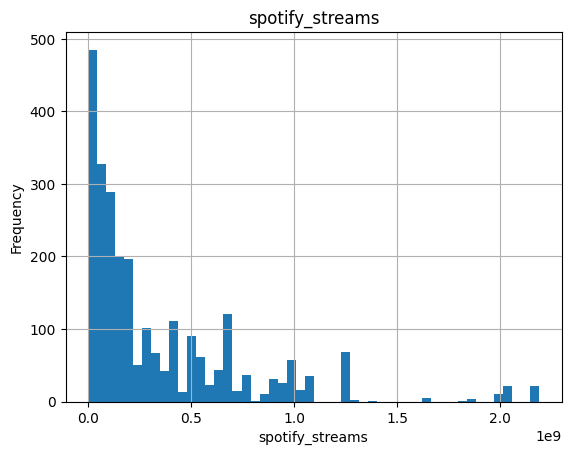

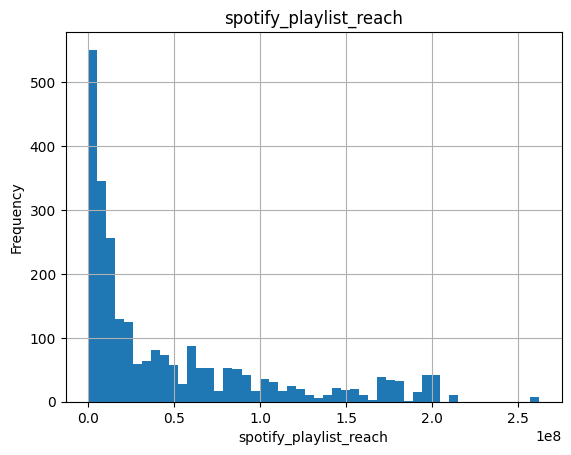

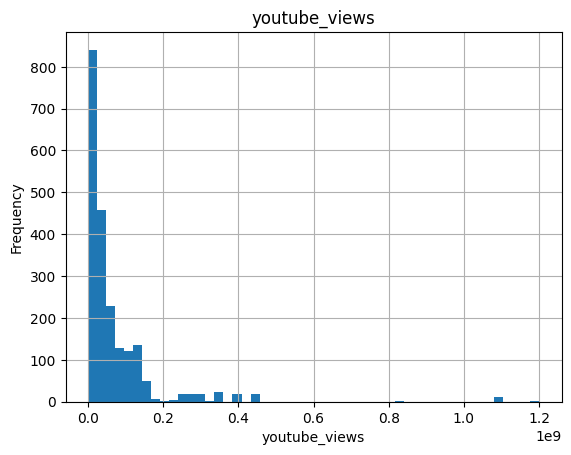

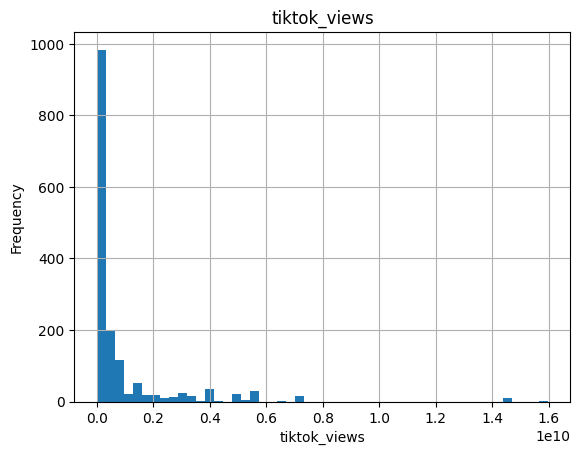

In [198]:
import matplotlib.pyplot as plt

cols_to_plot = [
    'spotify_streams', 'spotify_playlist_reach',
    'youtube_views', 'tiktok_views'
]

for col in cols_to_plot:
    final[col].dropna().hist(bins=50)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

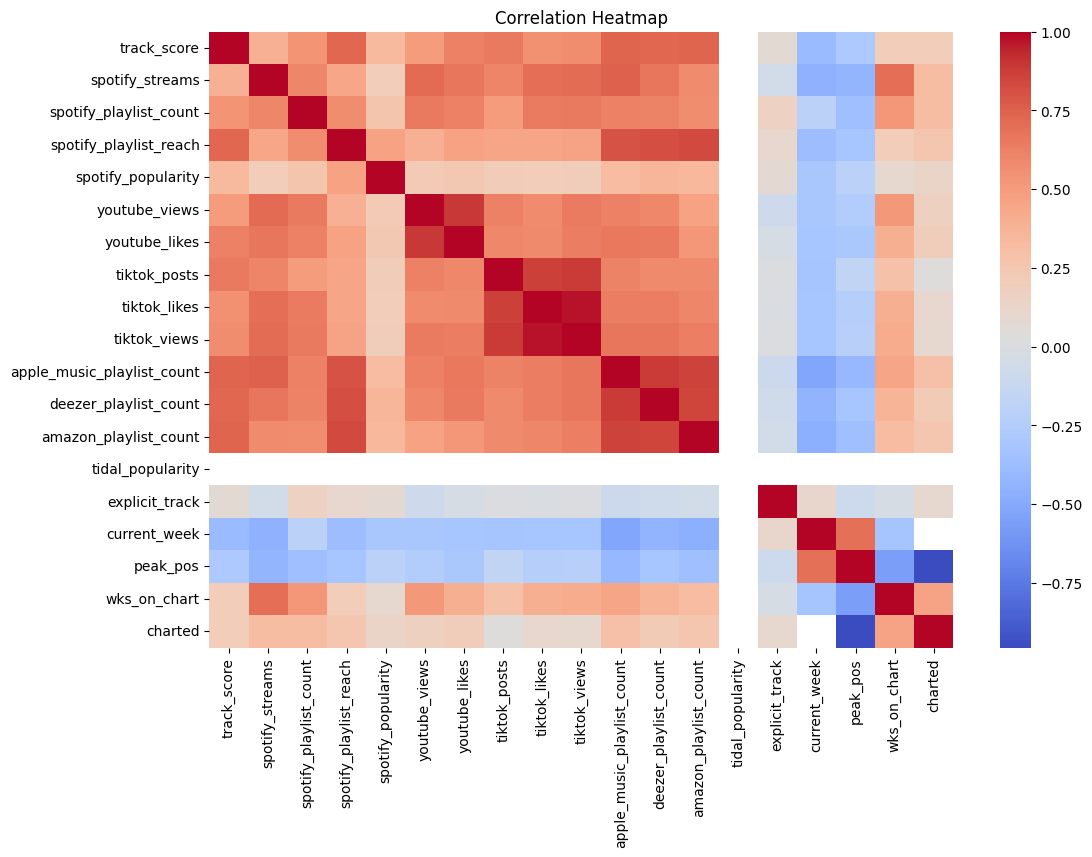

In [167]:
numeric_cols = final.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

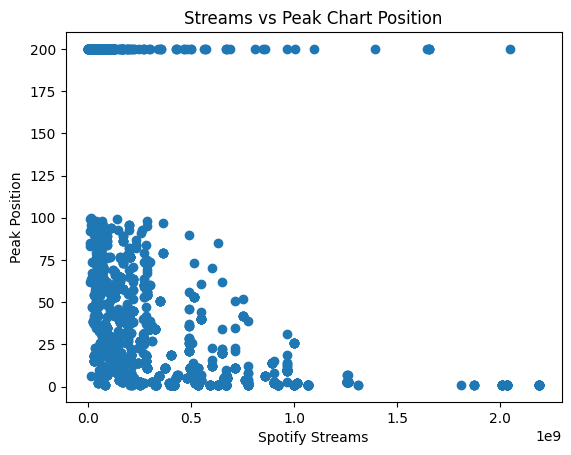

In [168]:
plt.scatter(final['spotify_streams'], final['peak_pos'])
plt.xlabel("Spotify Streams")
plt.ylabel("Peak Position")
plt.title("Streams vs Peak Chart Position")
plt.show()

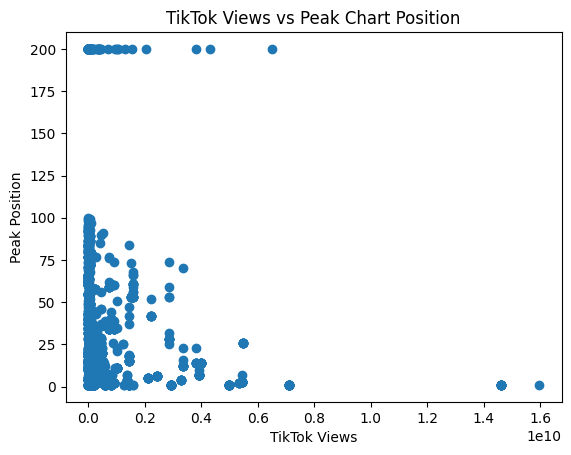

In [169]:
plt.scatter(final['tiktok_views'], final['peak_pos'])
plt.xlabel("TikTok Views")
plt.ylabel("Peak Position")
plt.title("TikTok Views vs Peak Chart Position")
plt.show()

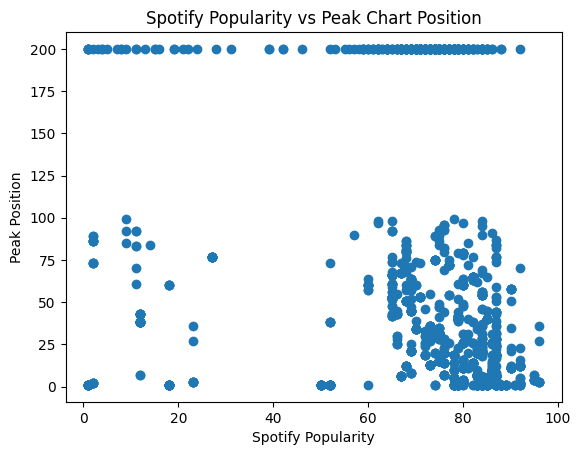

In [170]:
plt.scatter(final['spotify_popularity'], final['peak_pos'])
plt.xlabel("Spotify Popularity")
plt.ylabel("Peak Position")
plt.title("Spotify Popularity vs Peak Chart Position")
plt.show()